In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=722e09b907c098cb2884054d75d8ec3496420ed722558aaf15dd652698d215fd
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, isnan, col
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, StringIndexer, OneHotEncoder, VectorAssembler

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

### **Reading the dataset**

In [4]:
spark = SparkSession.builder.master("local[2]").appName("PySpark-TitanicData").getOrCreate()

In [5]:
fileLocation = '/content/TitanicData.csv'

data = spark.read.csv(fileLocation, header=True, inferSchema=True)

Here, header=True tells PySpark to use the first row of the CSV file as column names, and inferSchema=True tells PySpark to automatically infer the data types of each column.

##### **Data Overview**

In [6]:
data.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)
 |-- Survived: integer (nullable = true)



##### **Columns Overview**

In [7]:
pd.DataFrame(data.dtypes, columns = ['Column','Data type'])

,Column,Data type
0,PassengerId,int
1,Pclass,int
2,Name,string
3,Sex,string
4,Age,double
5,SibSp,int
6,Parch,int
7,Ticket,string
8,Fare,double
9,Cabin,string


##### **Preview the first five rows**

In [8]:
data.show(5)

+-----------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+--------+
|PassengerId|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|Survived|
+-----------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+--------+
|          1|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|       0|
|          2|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|       1|
|          3|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|       1|
|          4|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|       1|
|          5|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|       0|
+-----------+------+--------------------+------+----+-----+-----+---------------

##### **Summary statistics of the data set**

In [9]:
data.describe().show()

+-------+-----------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+-------------------+
|summary|      PassengerId|            Pclass|                Name|   Sex|               Age|             SibSp|              Parch|            Ticket|             Fare|Cabin|Embarked|           Survived|
+-------+-----------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+-------------------+
|  count|              891|               891|                 891|   891|               714|               891|                891|               891|              891|  204|     889|                891|
|   mean|            446.0| 2.308641975308642|                null|  null| 29.69911764705882|0.5230078563411896|0.38159371492704824|260318.54916792738| 32.2042079685746| null|    n

### **Data Pre-Processing & Cleaning**

##### **Adding "Title" column in the data**

The data frame has Name column which have names of every passenger who were onboard in the titanic, this column will be used to extract the Title from it so that it will be further used in the analysis.

In [10]:
titles = regexp_extract(col("Name"),"([A-Za-z]+)\.",1)
data = data.withColumn('Title', titles)

In [11]:
data.groupby("Title").count().show()

+--------+-----+
|   Title|count|
+--------+-----+
|     Don|    1|
|    Miss|  182|
|Countess|    1|
|     Col|    2|
|     Rev|    6|
|    Lady|    1|
|  Master|   40|
|     Mme|    1|
|    Capt|    1|
|      Mr|  517|
|      Dr|    7|
|     Mrs|  125|
|     Sir|    1|
|Jonkheer|    1|
|    Mlle|    2|
|   Major|    2|
|      Ms|    1|
+--------+-----+



We can see that majority of the titles are correctly extracted with a few titles that can belong to "Officer" category (such as Capt, Col, etc.). We also create "Others" category which can include Dr, Rev', etc. Moreover we merge those rows which are similar (such as "Miss" and "Ms"), and drop those rows with unknown titles (such as Countess).

In [12]:
data = data.replace(['Capt', 'Col', 'Major', 'Dr', 'Rev', 'Lady', 'Sir', 'Ms'], 
             ['Officer', 'Officer', 'Officer', 'Other', 'Other', 'Miss', 'Mr', 'Miss'])

data = data.filter((data['Title'] != 'Don') & (data['Title'] != 'Countess') & (data['Title'] != 'Mme') & 
                  (data['Title'] != 'Jonkheer') & (data['Title'] != 'Mlle'))

In [13]:
data.groupby("Title").count().show()

+-------+-----+
|  Title|count|
+-------+-----+
|   Miss|  184|
|Officer|    5|
|  Other|   13|
| Master|   40|
|     Mr|  518|
|    Mrs|  125|
+-------+-----+



We can see now that we have filtered the titles and we are left with 6 categories.

##### **Adding more category in title based on 'Parch' column**

The title of 'Miss' was given to all females who were unmarried, regardless of their age. However, within this group of unmarried females, there were both young girls and adult women who likely had significantly different average ages.

We can use a logical approach to differentiate between the two situations. If the value of Parch is greater than 0, it's probable that the females are children who are traveling with at least one parent. In this case, we can refer to them as 'Miss_Ch.' On the other hand, if the value of Parch is equal to 0, it's likely that the females are adult women traveling alone. We can designate them as 'Miss_Ad.'

In [14]:
data = data.withColumn("NewTitle", when((data.Title=="Miss") & (data.Parch==0), 'Miss_Ad')
.when((data.Title=="Miss") & (data.Parch!=0), 'Miss_Ch')
.otherwise(data['Title']))

In [15]:
data.groupby("NewTitle").count().show()

+--------+-----+
|NewTitle|count|
+--------+-----+
| Officer|    5|
|   Other|   13|
|  Master|   40|
| Miss_Ad|  120|
|      Mr|  518|
|     Mrs|  125|
| Miss_Ch|   64|
+--------+-----+



##### **Count of null/na entries in all of the columns**

In [16]:
nullStats = data.select([count(when(isnan(col(column)) | col(column).isNull(), column)).alias(column) for column in data.columns])
nullStats.show()

+-----------+------+----+---+---+-----+-----+------+----+-----+--------+--------+-----+--------+
|PassengerId|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|Survived|Title|NewTitle|
+-----------+------+----+---+---+-----+-----+------+----+-----+--------+--------+-----+--------+
|          0|     0|   0|  0|177|    0|    0|     0|   0|  685|       2|       0|    0|       0|
+-----------+------+----+---+---+-----+-----+------+----+-----+--------+--------+-----+--------+



We can see that there are quite a lot of missing entries in the 'Age' and 'Cabin' column with 177 missing values in the Age column and 687 missing values in the Cabin column. Whereas 'Embarked' column has only two missing entries.

##### **Imputing missing values in the 'Age' column**

Since Age is an important feature for this project, therefore it was important to perform the previous step in which we created new column named NewTitle, it was important for this step since we will now be imputing the missing value of Age based on the mean value of the grouped "NewTitle", and "PClass" hence getting the missing values with higher certainity of being correct.

In [17]:
groupAges = data.groupby(['NewTitle', 'Pclass']).avg(('Age')).collect()

In [18]:
groupAgesDict = {}
for row in groupAges:
  key = (row.NewTitle, row.Pclass)
  value = row["avg(Age)"]
  if key not in groupAgesDict:
      groupAgesDict[key] = value
  else:
      groupAgesDict[key].append(value)

In [19]:
index = 1
for (title, pclass), imputed_age in groupAgesDict.items():
  data = data.withColumn(
      "AgeImputed_" + str(index) ,
      when(
          (data['NewTitle'] == title) &
          (data['Pclass'] == pclass) &
          (data['Age'].isNull()), imputed_age
      ).otherwise(data.Age)
  )
  index = index + 1
  

In [20]:
data = data.withColumn("AgeFilled", coalesce('AgeImputed_1', 'AgeImputed_2', 'AgeImputed_3', 'AgeImputed_4', 'AgeImputed_5',
                                             'AgeImputed_6', 'AgeImputed_7', 'AgeImputed_8', 'AgeImputed_9', 'AgeImputed_10',
                                             'AgeImputed_11', 'AgeImputed_12', 'AgeImputed_13', 'AgeImputed_14',
                                             'AgeImputed_15', 'AgeImputed_16', 'AgeImputed_17', 'AgeImputed_18'))

In [21]:
data.show()

+-----------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+--------+------+--------+------------------+------------+------------+------------+------------+------------+------------+------------+------------+-----------------+-------------+-------------+-------------+------------------+-------------+-------------+-------------+-------------+------------------+
|PassengerId|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|Survived| Title|NewTitle|      AgeImputed_1|AgeImputed_2|AgeImputed_3|AgeImputed_4|AgeImputed_5|AgeImputed_6|AgeImputed_7|AgeImputed_8|AgeImputed_9|    AgeImputed_10|AgeImputed_11|AgeImputed_12|AgeImputed_13|     AgeImputed_14|AgeImputed_15|AgeImputed_16|AgeImputed_17|AgeImputed_18|         AgeFilled|
+-----------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+--------+------+--------+------------------+------------+------------+---------

Dropping the columns created in between to clean the data frame.

In [22]:
data = data.drop('Age', 'Title', 'AgeImputed_1', 'AgeImputed_2', 'AgeImputed_3', 'AgeImputed_4', 'AgeImputed_5','AgeImputed_6',
                 'AgeImputed_7', 'AgeImputed_8', 'AgeImputed_9', 'AgeImputed_10', 'AgeImputed_11', 'AgeImputed_12',
                 'AgeImputed_13', 'AgeImputed_14', 'AgeImputed_15', 'AgeImputed_16', 'AgeImputed_17', 'AgeImputed_18')

In [23]:
nullStats = data.select([count(when(isnan(col(column)) | col(column).isNull(), column)).alias(column) for column in data.columns])
nullStats.show()

+-----------+------+----+---+-----+-----+------+----+-----+--------+--------+--------+---------+
|PassengerId|Pclass|Name|Sex|SibSp|Parch|Ticket|Fare|Cabin|Embarked|Survived|NewTitle|AgeFilled|
+-----------+------+----+---+-----+-----+------+----+-----+--------+--------+--------+---------+
|          0|     0|   0|  0|    0|    0|     0|   0|  685|       2|       0|       0|        0|
+-----------+------+----+---+-----+-----+------+----+-----+--------+--------+--------+---------+



##### **Imputing missing values in the 'Embarked' column**

Since this feature has only two missing values, therefore we will impute the missing values using the mode of the column. And we can see in the below cell that the mode value of this columns is 'S', therefore we will replace null values in this column by the value "S".

In [24]:
data.groupby("Embarked").count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|    null|    2|
|       C|  164|
|       S|  642|
+--------+-----+



In [25]:
data = data.na.fill({"Embarked" : 'S'})

##### **Count of duplicate rows in the data set**

In [26]:
results = data.groupBy(data.columns)\
            .agg(expr('count(*) as count'))\
            .filter(expr('count > 1'))\
            .select(sum('count').alias('total_count'))

results.show()

+-----------+
|total_count|
+-----------+
|       null|
+-----------+



We can see that the output shows us that there are no duplicate entries in the dataset

### **Data Visualization & Analysis**

In this part of the notebook, we will try to analyse the different variables in the dataset with Survival variable to get how it is correlated with  different features such as 'Sex', 'Fare', 'Pclass', 'Cabin', etc.

##### **Number of passengers based on Sex**

In [27]:
passengerCount = data.groupby("Sex").count()

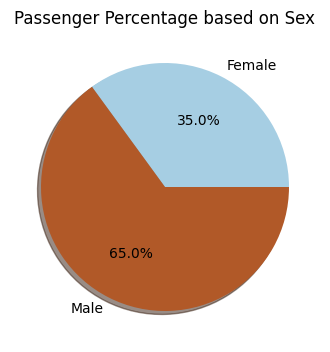

In [28]:
passengerCount.toPandas().plot(kind = 'pie', y = 'count', labels = ['Female', 'Male'], figsize = (4,5),
                               title = 'Passenger Percentage based on Sex', legend=False, autopct='%1.1f%%', 
                               shadow=True, startangle=0, cmap = 'Paired')
plt.ylabel('')
plt.show()

We can see that there is a high percentage of people who are Male which is 65%, whereas only 35% of the passengers were females in Titanic.

##### **Survival rate based on Sex**

In [29]:
sexSurvival = data.groupBy("Sex","Survived").count()
sexSurvival = sexSurvival.withColumn('percentage', round(sexSurvival['count']/data.count() * 100, 2))

In [30]:
sexSurvival.show()

+------+--------+-----+----------+
|   Sex|Survived|count|percentage|
+------+--------+-----+----------+
|  male|       0|  466|     52.66|
|female|       1|  229|     25.88|
|female|       0|   81|      9.15|
|  male|       1|  109|     12.32|
+------+--------+-----+----------+



From the above table, we can see that more than 50% of the total passengers were not survived in Titanic and only 12.32% of the males were survived. Despite having a smaller proportion of the females, around 26% of them were survived only 9.15% couldn't survive. This means that overall, the survival rate of females was higher than males.

##### **Number of passengers based on Age Groups**

In [31]:
pdData = data.toPandas()

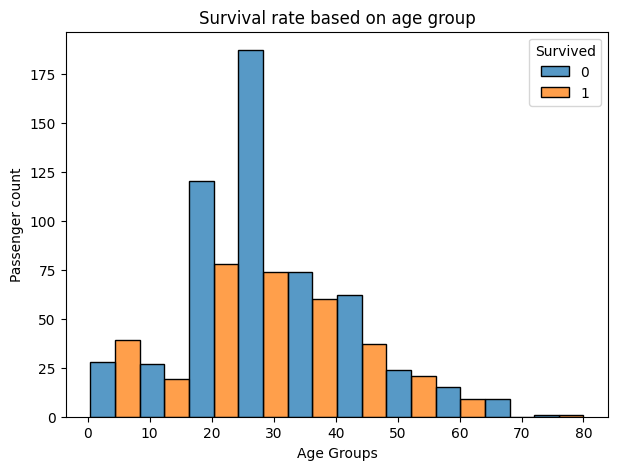

In [32]:
plt.figure(figsize = (7,5))
sns.histplot(x = pdData["AgeFilled"], hue = pdData["Survived"], multiple = "dodge", bins = 10)
plt.title('Survival rate based on age group')
plt.xlabel('Age Groups')
plt.ylabel('Passenger count')
plt.show()

##### **Number of passengers based on Embarked**

In [33]:
passengerCount = data.groupby("Embarked").count()

In [34]:
passengerCount.show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|       C|  164|
|       S|  644|
+--------+-----+



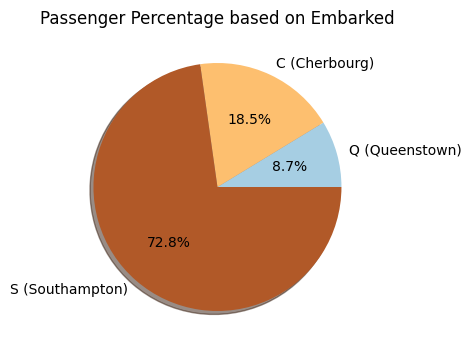

In [35]:
passengerCount.toPandas().plot(kind = 'pie', y = 'count', labels = ['Q (Queenstown)', 'C (Cherbourg)', 'S (Southampton)'], 
                               figsize = (4,5), title = 'Passenger Percentage based on Embarked', legend=False,
                               autopct='%1.1f%%', shadow=True, startangle=0, cmap = 'Paired')
plt.ylabel('')
plt.show()

We can see from the above pie-plot that more than 70% of the passenger embarked from Southampton, whereas 18.5% of the people embarked from Cherbourg, and only 8.7% of the people embarked from Queenstown.

##### **Passenger Survival based on Embarked**

In [36]:
embarkedSurvival = data.groupby("Embarked", "Survived").count()

In [37]:
embarkedSurvival = embarkedSurvival.withColumn('percentage', round(embarkedSurvival['count']/data.count() * 100, 2))

In [38]:
embarkedSurvival.show()

+--------+--------+-----+----------+
|Embarked|Survived|count|percentage|
+--------+--------+-----+----------+
|       Q|       1|   30|      3.39|
|       S|       0|  426|     48.14|
|       S|       1|  218|     24.63|
|       C|       1|   90|     10.17|
|       Q|       0|   47|      5.31|
|       C|       0|   74|      8.36|
+--------+--------+-----+----------+



According to the available data, it appears that the passengers who embarked on the Titanic from Cherbourg had a significantly higher chance of survival compared to those who boarded from Southampton. In fact, the survival rate of those who boarded from Cherbourg was greater than 50%, indicating that a majority of them managed to survive the tragic event.

On the other hand, travellers who boarded from Southampton had the lowest actual chance of survival, which was estimated to be around 33%. This suggests that the passengers who embarked from Southampton were at a significant disadvantage when it came to surviving the disaster.

##### **Correlation Heatmap between different variables**

<ipython-input-39-d33d01acb8fa>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.toPandas().corr(), cmap = 'viridis')


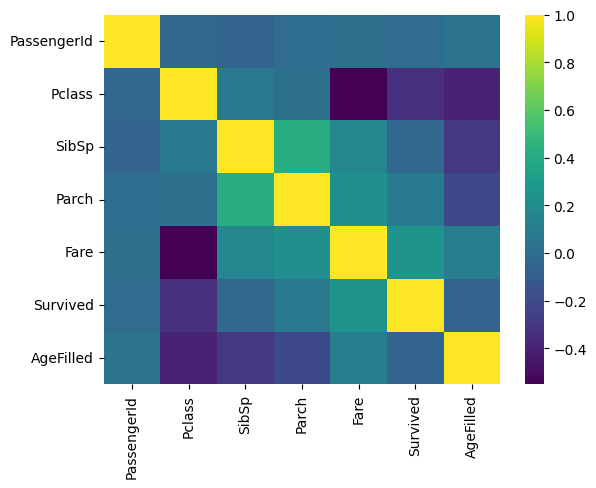

In [39]:
sns.heatmap(data.toPandas().corr(), cmap = 'viridis')
plt.show()

### **Feature Selection**

We will select only those columns that will be useful for us in performing the machine learning classification. Since it is reduntant and useless to include the features which don't add any value to the trained machine learning model, therefore we remove such columns. We remove 'PassengerId', 'Name', 'Ticket', and 'Cabin' from the data set.

In [40]:
data = data.drop('PassengerId', 'Name', 'Ticket', 'Cabin')

In [41]:
data.show(5)

+------+------+-----+-----+-------+--------+--------+--------+---------+
|Pclass|   Sex|SibSp|Parch|   Fare|Embarked|Survived|NewTitle|AgeFilled|
+------+------+-----+-----+-------+--------+--------+--------+---------+
|     3|  male|    1|    0|   7.25|       S|       0|      Mr|     22.0|
|     1|female|    1|    0|71.2833|       C|       1|     Mrs|     38.0|
|     3|female|    0|    0|  7.925|       S|       1| Miss_Ad|     26.0|
|     1|female|    1|    0|   53.1|       S|       1|     Mrs|     35.0|
|     3|  male|    0|    0|   8.05|       S|       0|      Mr|     35.0|
+------+------+-----+-----+-------+--------+--------+--------+---------+
only showing top 5 rows



Since now we are only left with only a few rows which might have the null values, therefore we drop these rows

In [45]:
data = data.dropna()

In [44]:
print('Length of data after dropping the rows with null values:', data.count())

Length of data after dropping the rows with null values: 885


### **Machine Learning Classification**

##### **Creating Pipeline**

This chunk of code has been referenced from: https://www.kaggle.com/code/dev523/pyspark-ml-model-for-predicting-titanic-passenger

In [47]:
stages = []
categorical_columns = ['Sex', 'Embarked', 'Pclass', 'NewTitle']

In [48]:
for catCol in categorical_columns:
  indexer = StringIndexer(inputCol = catCol, outputCol = catCol + 'Index', stringOrderType = 'frequencyDesc')
  encoder = OneHotEncoder(inputCols = [indexer.getOutputCol()], outputCols = [catCol+'catVec'])
  stages += [indexer, encoder]

In [49]:
numeric=['Fare','SibSp','Parch','AgeFilled']

In [50]:
assembleInputs = [c + 'catVec' for c in categorical_columns] + numeric
assembler = VectorAssembler(inputCols = assembleInputs, outputCol = "features")
stages += [assembler]

##### **Train-Test Split**

In [51]:
trainData, testData = data.randomSplit([0.8, 0.2], seed = 9) 

pipeline = Pipeline().setStages(stages)
pipelineModel = pipeline.fit(trainData)

In [52]:
trainPipe = pipelineModel.transform(trainData)
testPipe = pipelineModel.transform(testData)

In [60]:
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import classification_report

##### **Random Forest Classification**

In [54]:
rf = RandomForestClassifier(labelCol = 'Survived', predictionCol = 'prediction', seed = 9)

rfmodel = rf.fit(trainPipe)

In [55]:
pred_results_rf = rfmodel.transform(testPipe)

##### **Test Prediction & Accuracy Assessment - Random Forest**

In [80]:
# For the Training Set
summary = rfmodel.summary
print('The training accuracy of the model is:', str(summary.accuracy)[0:6])

The training accuracy of the model is: 0.8551


In [57]:
y_true = pred_results_rf.select(['Survived']).collect()
y_pred = pred_results_rf.select(['prediction']).collect()

In [58]:
print("Classification Report for Random Forest:\n")
print(classification_report(y_true, y_pred))

Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.81      0.94      0.87        97
           1       0.89      0.70      0.78        70

    accuracy                           0.84       167
   macro avg       0.85      0.82      0.83       167
weighted avg       0.85      0.84      0.83       167



For the random forest, the model’s accuracy on the training data is **0.8551**, which is quite high. Table shows a lot of information about the accuracy of the model. Looking at the precision, recall, and F1-score for each class, we can see that the model has higher precision for class 1 (0.89) than for class 0 (0.81), indicating that when the model predicts an instance as belonging to class 1, it is more likely to be correct. However, the recall for class 1 (0.70) is lower than that for class 0 (0.94), which means that the model may have missed some instances belonging to class 1. The macro average and weighted average of the precision, recall, and F1-score are both around 0.83, which suggests that the model's performance is roughly consistent across both classes.

##### **Logistic Regression Classification**

In [62]:
lr = LogisticRegression(labelCol = 'Survived', predictionCol = 'prediction')

lrModel = lr.fit(trainPipe)

In [64]:
pred_results_lr = lrModel.transform(testPipe)

##### **Test Prediction & Accuracy Assessment - Logistic Regression**

In [81]:
# For the Training Set
summary = lrModel.summary
print('The training accuracy of the model is:', str(summary.accuracy)[0:6])

The training accuracy of the model is: 0.8328


In [66]:
y_true = pred_results_lr.select(['Survived']).collect()
y_pred = pred_results_lr.select(['prediction']).collect()

In [67]:
print("Classification Report for Logistic Regression:\n")
print(classification_report(y_true, y_pred))

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.80      0.92      0.86        97
           1       0.86      0.69      0.76        70

    accuracy                           0.82       167
   macro avg       0.83      0.80      0.81       167
weighted avg       0.82      0.82      0.82       167



For logistic regression, the model’s overall accuracy on the training data is **0.8328**. The model achieved an overall accuracy of 0.82, which means that it correctly classified 82% of the instances in the dataset. The precision, recall, and F1-score for each class shows us that the model has higher precision for class 1 (0.86) than for class 0 (0.80), indicating that when the model predicts an instance as belonging to class 1, it is more likely to be correct. However, the recall for class 1 (0.69) is much lower than that for class 0 (0.92), which means that the model may have missed some instances belonging to class 1. The F1-score provides an overall measure of the model's performance for each class. In this case, the F1-score for class 0 is higher (0.86) than that for class 1 (0.76).

### Discussion & Conclusion

We see that the methodology which we followed helped us creating the machine learning models perform good. Moreover, the choice of our pre-processing and cleaning data was indeed a major step which helped to maintain the data quality and consistency. After performing the visual analysis, we saw that the variables are quite correlated with each other, which might be one of the reasons that our machine learning model performed well. But comparing the two classification models, we can see that the random forest model had a slightly higher overall accuracy (0.84) than the logistic regression (0.82). However, the performance of the two models varied for each class. Overall, while the model's performance appears to be reasonably good, but there is still scope for improvement. Therefore, further analysis and fine-tuning may help to improve the model’s accuracy in predicting both the classes. In the case of the random forest model, further tuning may help to improve its precision for class 1, while for the logistic regression model, further tuning might to improve its recall for class 1. It is also possible that a different type of model may perform better for this data. Therefore, it may be worthwhile to explore other types of models and further analyse the data to improve the overall accuracy of the model.